# Importing Libraies

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from nltk.stem import PorterStemmer
import time
import matplotlib.pyplot as plt
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kritarth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kritarth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kritarth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Exploration
## dataset link : https://data.world/crowdflower/apple-twitter-sentiment

In [3]:
df = pd.read_csv('apple_twitter_sentiment_dfe.csv',usecols=['sentiment','text'])
df.sample(5)

,sentiment,text
1943,3,"RT @OneRepublic: Studio at 45,000 ft. One out..."
1978,3,#Apple planning to support 500 #Apple reseller...
1318,3,Is Apple The Most Important Stock On Earth? h...
398,3,iPad Mini First Time Startup!: http://t.co/vGH...
741,3,RT @JPDesloges: GTAT Creditors Want to Questio...


In [4]:
sentiment_map = {0:'negative',1:'nuetral',2:'positive'}
# 1 negative 3 nuetral 5 positive ====> 0 negative 1 nuetral 2 positive
df.drop(df[df['sentiment']=='not_relevant'].index, inplace = True) 
df['sentiment'] = df['sentiment'].apply(lambda x:(int(x)-1)//2)
df.sample(10)

,sentiment,text
2620,0,@L2DAWASHINGTON @Apple I hope them faggots get...
2909,1,RT @yungjoseg: Poor dudes out here gettin slan...
3229,0,"Good grief, @Apple, could you all have a more ..."
3613,2,#apple earns more #profit in on quarter than #...
1211,2,#Apple Is Now Worth More Than The Entire Russi...
3406,1,RT @TeamCavuto: Protesters stage #DieIn protes...
1132,1,@Apple why isn't there an otter emoji
2860,1,RT @FrankThePilot: can we get a touch screen m...
3150,1,Massive mobile tech companies like @apple @xia...
422,0,@apple really needs to do something about thes...


In [5]:
df.dtypes

sentiment     int64
text         object
dtype: object

In [6]:
print("Negative : {}".format((df.sentiment==0).sum()))
print("Nuetral : {}".format((df.sentiment==1).sum()))
print("Positive : {}".format((df.sentiment==2).sum()))

Negative : 1219
Nuetral : 2162
Positive : 423


# Preprocessing

In [7]:
def lower_text(input_text):
    return input_text.lower()

def remove_punctuations(input_text):
    input_text = re.sub(r'[^\w\s@#]', '', input_text)
    return input_text

def remove_at(input_text):
    input_text = re.sub(r'\@\w+$','',input_text)
    input_text = re.sub(r'\@\w+(\s)','',input_text)
    return input_text

def remove_url(input_text):
    input_text = re.sub(r'https?\S+(\s)','',input_text)
    input_text = re.sub(r'pic?\S+(\s)','',input_text)
    input_text = re.sub(r'https?\S+$','',input_text)
    input_text = re.sub(r'pic?\S+$','',input_text)
    return input_text

def extract_hashtags(input_text):
    hashtags1 = re.findall('[#$]\w+\s',input_text)
    hashtags2 = re.findall('[#$]\w+$',input_text)
    hashtags = hashtags1 + hashtags2
    for i in range(len(hashtags)):
        hashtags[i] = hashtags[i].strip()[1:]
    return ' '.join(hashtags)
    
def remove_hashtags(input_text):
    input_text = re.sub('[#$]\w+\s',' ',input_text)
    return re.sub('[#$]\w+$',' ',input_text)

def remove_encoded_words(input_text):
    return re.sub(r'[^\x00-\x7F]+',' ', input_text)

def remove_noise(input_text):
    input_text = re.sub(r'^rt',' ',input_text)
    input_text = re.sub(r'\W',' ',input_text)
    input_text = re.sub(r'\d',' ',input_text)
    input_text = re.sub(r'\s+',' ',input_text)
    return input_text

In [8]:
def clean_text(input_text):
    sentences = sent_tokenize(input_text)
    for i in range(len(sentences)):
        sentences[i] = lower_text(sentences[i])
        sentences[i] = remove_punctuations(sentences[i])
        sentences[i] = remove_at(sentences[i])
        sentences[i] = remove_url(sentences[i])
        sentences[i] = remove_hashtags(sentences[i])
        sentences[i] = remove_encoded_words(sentences[i])
        sentences[i] = remove_noise(sentences[i])
        words = word_tokenize(sentences[i])
        new = []
        for word in words:
            if word not in stopwords.words('english'):
                new.append(word)
        sentences[i] = ' '.join(new)
    return sentences

In [9]:
def lematization(sentences):
    lem = WordNetLemmatizer()
    for i in range(len(sentences)):
        words = nltk.word_tokenize(sentences[i])
        words = [lem.lemmatize(word,pos='v') for word in words]
        sentences[i] = ' '.join(words)
    return sentences

def stemming(sentences):
    stemmer = PorterStemmer()
    for i in range(len(sentences)):
        words = nltk.word_tokenize(sentences[i])
        words = [stemmer.stem(word) for word in words]
        sentences[i] = ' '.join(words)
    return sentences

def spell_correction(sentences):
    lem = WordNetLemmatizer()
    for i in range(len(sentences)):
        words = nltk.word_tokenize(sentences[i])
        words = [str(TextBlob(word).correct()) for word in words]
        words = [lem.lemmatize(word,pos='v') for word in words]
        sentences[i] = ' '.join(words)
    return sentences

In [10]:
def technique1(input_text):
    sentences = clean_text(input_text)
    sentences = lematization(sentences)
    return ' '.join(sentences)

def technique2(input_text):
    sentences = clean_text(input_text)
    sentences = stemming(sentences)
    return ' '.join(sentences)

def technique3(input_text):
    sentences = clean_text(input_text)
    sentences = spell_correction(sentences)
    return ' '.join(sentences)

In [11]:
time_taken = []
start = time.time()
df['text_lematized'] = df['text'].apply(technique1)
time_taken.append(time.time()-start)
print('Technique 1 completed')
start = time.time()
df['text_stemmed'] = df['text'].apply(technique2)
time_taken.append(time.time()-start)
print('Technique 2 completed')
# Spell check takes very long
'''
start = time.time()
df['text_spell_checked'] = df['text'].apply(technique3)
time_taken.append(time.time()-start)
print('Technique 3 completed')
'''
df['hashtags'] = df['text'].apply(extract_hashtags)
df.sample(5)

Technique 1 completed
Technique 2 completed


,sentiment,text,text_lematized,text_stemmed,hashtags
1131,0,over 1 hour on hold with @apple customer servi...,hour hold customer service try figure messup,hour hold custom servic tri figur messup,
888,1,Apple Price-Target Rises to $140 http://t.co/q...,apple pricetarget rise,appl pricetarget rise,140 Apple AAPL
789,0,@SaifBinS3eed @Apple get the cloud to butt ext...,get cloud butt extension web browser,get cloud butt extens web browser,
3787,1,Apple iPod class action trial to continue temp...,apple ipod class action trial continue tempora...,appl ipod class action trial continu temporari...,AAPL aapl
699,1,Steve Jobs emails featured in Apple iPod US an...,steve job email feature apple ipod us antitrus...,steve job email featur appl ipod us antitrust ...,AAPL


# View Random Tweet

In [12]:
def random_tweet(df):
    i = random.randint(0,df.shape[0])
    print("Tweet : {}".format(df['text'][i]))
    print("\nSentiment : {}".format(sentiment_map[df['sentiment'][i]])) 
    print("\nLematized Tweet : {}".format(df['text_lematized'][i]))
    print("\nStemmed Tweet : {}".format(df['text_stemmed'][i]))
    print("\nHashtags : {}".format(extract_hashtags(df['text'][i])))

In [13]:
random_tweet(df)

Tweet : @zoee_janoskians @Apple WHAT HAPPENED OMD

Sentiment : nuetral

Lematized Tweet : happen omd

Stemmed Tweet : happen omd

Hashtags : 


# Comparision of techniques based on time taken

<BarContainer object of 2 artists>

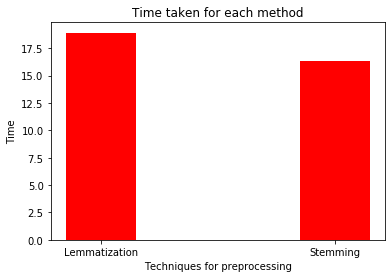

In [14]:
plt.title('Time taken for each method')
plt.ylabel('Time')
plt.xlabel('Techniques for preprocessing')
plt.bar(['Lemmatization','Stemming'],time_taken,width=0.3,color='r')

# Training Bayes and SVM models
## Stemming takes less time hence technique 2 is used

In [15]:
train_percent = 0.90

while True:
    choice = int(input('Enter 0 for Stemming and 1 for Lemmatization : '))
    if choice==0:
        X = list(df['text_stemmed'])
        break
    elif choice==1:
        X = list(df['text_lematized'])
        break
    else:
        continue
X_hashed = list(df['hashtags'])
Y = list(df['sentiment'])
X_train = X[:int(train_percent*len(X))]
Y_train = Y[:int(train_percent*len(X))]
X_hashed_train = X_hashed[:int(train_percent*len(X))]
X_test = X[int(train_percent*len(X)):]
Y_test = Y[int(train_percent*len(X)):]
X_hashed_test = X_hashed[int(train_percent*len(X)):]

Enter 0 for Stemming and 1 for Lemmatization : 0


In [16]:
def confusionMatrix(Y_test,Y_pred):
    cm = confusion_matrix(Y_test, Y_pred,labels=[0,1,2],normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['negative','nuetral','positive'])
    disp.plot(cmap='Blues',xticks_rotation='vertical')

In [17]:
model_bayes_text = make_pipeline(TfidfVectorizer(),MultinomialNB())

model_bayes_text.fit(X_train,Y_train)

Y_pred = model_bayes_text.predict(X_test)

Accuracy : 0.7007874015748031


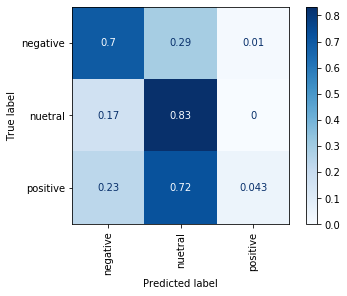

In [18]:
print("Accuracy : {}".format(model_bayes_text.score(X_test,Y_test)))
confusionMatrix(Y_test,Y_pred)

In [24]:
def predict_sentiment(model,X,X_hashed,alpha=0.2):
    Y_pred_text = model.predict_proba(X)
    Y_pred = []
    for i in range(len(X)):
        if X_hashed[i]!='':
            Y_pred_text[i] = (1-alpha)*Y_pred_text[i]+alpha*model.predict_proba([X_hashed[i]])
        score = Y_pred_text[i][1]+2*Y_pred_text[i][2]
        if score>=1.1:
            Y_pred.append(2)
        elif score<=0.70:
            Y_pred.append(0)
        else:
            Y_pred.append(1)
    return Y_pred 

def accuracy(Y_test,Y_pred):
    score = 0
    for i in range(len(Y_test)):
        if Y_test[i]==Y_pred[i]:
            score+=1
    return float(score)/len(Y_test)

Accuracy : 0.7139107611548556


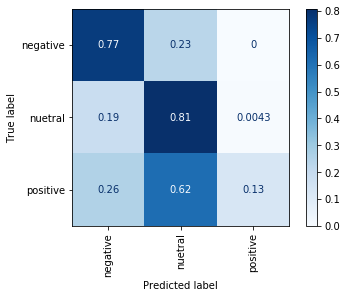

In [25]:
Y_pred = predict_sentiment(model_bayes_text,X_test,X_hashed_test)
print("Accuracy : {}".format(accuracy(Y_test,Y_pred)))
confusionMatrix(Y_test,Y_pred)

In [30]:
tweet = input('Enter tweet : ')
predict_sentiment(model_bayes_text,[technique2(tweet)],[extract_hashtags(tweet)])

Enter tweet : Good product #average


[1]

In [31]:
model_svm_text = make_pipeline(TfidfVectorizer(),SVC(probability=True))

model_svm_text.fit(X_train,Y_train)

Y_pred = model_svm_text.predict(X_test)

Accuracy : 0.7112860892388452


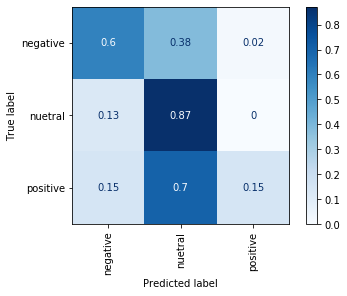

In [32]:
print("Accuracy : {}".format(model_svm_text.score(X_test,Y_test)))
confusionMatrix(Y_test,Y_pred)

Accuracy : 0.7007874015748031


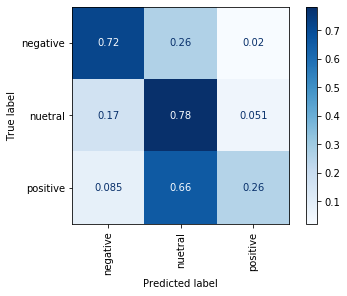

In [34]:
Y_pred = predict_sentiment(model_svm_text,X_test,X_hashed_test)
print("Accuracy : {}".format(accuracy(Y_test,Y_pred)))
confusionMatrix(Y_test,Y_pred)

In [35]:
tweet = input('Enter tweet : ')
predict_sentiment(model_svm_text,[technique2(tweet)],[extract_hashtags(tweet)])

Enter tweet : Great product #worth


[2]

# Performing Sentiment analysis on twitter data obtained using tweepy api
## SVM model performs better thus SVM with stemming as preprocessing technique is used

In [45]:
tweet_df = pd.read_csv('Tweets.csv',usecols=['tweet_text'])
tweet_df.dropna(inplace=True)
tweet_df.sample(5)

,tweet_text
90,"b'\xf0\x9f\x93\xa3 New Podcast! ""New Episode K..."
20,"b""Love #80s Music! It's #80s All The way to ..."
16,"b'\xf0\x9f\x93\xa3 New Podcast! ""New Episode K..."
85,b'just had a notification from @alexa99 to rev...
22,"b'Alexa, To be, or not to be | Amazon rolls ou..."


In [46]:
tweet_df['text_stemmed'] = tweet_df['tweet_text'].apply(technique2)
tweet_df['hashed'] = tweet_df['tweet_text'].apply(extract_hashtags)
X = list(tweet_df['text_stemmed'])
X_hashed = list(tweet_df['hashed'])
Y_pred = predict_sentiment(model_svm_text,X,X_hashed)

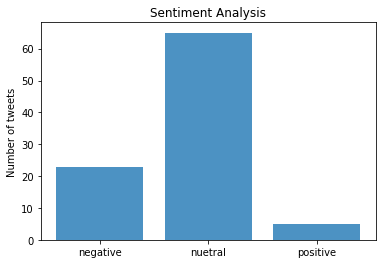

In [49]:
weights = [Y_pred.count(0),Y_pred.count(1),Y_pred.count(2)]
sentiments = ['negative','nuetral','positive']
y_pos = np.arange(len(sentiments))
plt.bar(y_pos, weights, align='center', alpha=0.8)
plt.xticks(y_pos, sentiments)
plt.ylabel('Number of tweets')
plt.title('Sentiment Analysis')
plt.show()